# CIFAR10 data classification using Wide Residual Network

#### Install necessary packeg to run in Google Colab

In [1]:
#!pip install keras
#apt-get -qq install -y graphviz && pip install -q pydot
!ls -l ./drive/MachineLearning/models/

total 283576
-rw-r--r-- 1 root root    633755 Mar  5 22:22 cifar10_simple_wrn1.png
-rw-r--r-- 1 root root 289161688 Mar  4 20:13 cifar10_simple_wrn.hdf5
-rw-r--r-- 1 root root    586234 Mar  5 20:55 cifar10_simple_wrn.png


## Import cifar10 from Keras dataset

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import cifar10
import keras.backend as K
import pickle

Using TensorFlow backend.


In [0]:
K.set_image_data_format('channels_last')

In [4]:
(trainImages, trainLabels), (testImages, testLabels) = cifar10.load_data()
print(('Training Images', trainImages.shape),('Training Labels',trainLabels.shape))
print(('Test Images', testImages.shape),('Test Labels',testLabels.shape))

('Training Images', (50000, 32, 32, 3)) ('Training Labels', (50000, 1))
('Test Images', (10000, 32, 32, 3)) ('Test Labels', (10000, 1))


In [0]:
def load_labels():
  #execute this command for the path
  #!ls ~/.keras/datasets/cifar-10-batches-py/batches.meta 
  filename = '/content/.keras/datasets/cifar-10-batches-py/batches.meta'
  labelsdict = None
  labels = []
  with open(filename, 'rb') as file:
    labelsdict = pickle.load(file,encoding='bytes')
  labels = [ x.decode('utf-8') for x in labelsdict[b'label_names'] ]
  return labels

In [6]:
labels = load_labels()
print(labels)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


#### Visualize training data

In [7]:
print(trainLabels.shape)
idx = np.where(trainLabels[:]==0)[0][0]
print(idx)

(50000, 1)
29


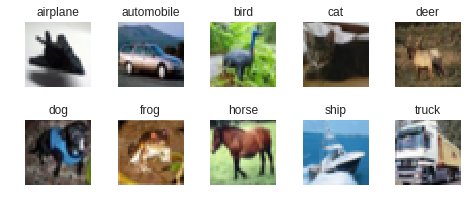

In [8]:
fig = plt.figure(figsize=(8,3))
figrows = 2
figcols = 5
for i in range(10):
  fig.add_subplot(figrows, figcols, 1 + i)
  idx = np.where(trainLabels[:]==i)[0][0]
  plt.imshow(trainImages[idx])
  plt.title(labels[trainLabels[idx][0]])
  plt.axis('off')
fig.subplots_adjust(hspace=0.5)
plt.show()

## Prepare data

Checking for GPU

In [0]:
from keras.utils import to_categorical

In [0]:
trainImages = trainImages.astype(np.float32) / 255
trainLabels = to_categorical(trainLabels, num_classes=10)
testImages = testImages.astype(np.float32) / 255
testLabels = to_categorical(testLabels, num_classes=10)

In [11]:
print(('Train Images', trainImages.shape), ('Train Labels', trainLabels.shape))
print(('Test Images', testImages.shape), ('Test Labels', testLabels.shape))

('Train Images', (50000, 32, 32, 3)) ('Train Labels', (50000, 10))
('Test Images', (10000, 32, 32, 3)) ('Test Labels', (10000, 10))


## Create WRN model
This is based on WRN described in https://arxiv.org/abs/1605.07146

In [0]:
from keras.layers import Input, ZeroPadding2D
from keras.layers import Conv2D, Activation
from keras.layers import MaxPooling2D, Dropout, BatchNormalization
from keras.layers import Flatten, Dense
from keras.models import Model
from keras.layers import Add

In [0]:
def create_wrn(input_shape=(32,32,3), num_classes=10,n=2, k=1):
  
  def _conv1(X):
    X = Conv2D(16, (3, 3), padding='same')(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    return X
  
  def _conv2(X, k=1):
    X_save = X
    
    X = Conv2D(16*k, (3, 3), padding='same')(X)
    X = Dropout(0.2)(X)
    X = Activation('relu')(X)
    X = Conv2D(16*k, (5, 5), padding='valid')(X)
    
    X_save = Conv2D(16*k, (5, 5), padding='valid')(X_save)
    
    X = Add()([X, X_save])
    
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    return X
  
  def _conv3(X, k=1):
    X_save = X
    
    X = Conv2D(32*k, (3, 3), padding='same')(X)
    X = Dropout(0.2)(X)
    X = Activation('relu')(X)
    X = Conv2D(32*k, (5, 5), padding='valid')(X)
    
    X_save = Conv2D(32*k, (5, 5), padding='valid')(X_save)
    
    X = Add()([X, X_save])
    
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    
    return X
  
  def _conv4(X, k=1):
    X_save = X
    
    X = Conv2D(64*k, (3, 3), padding='same')(X)
    X = Dropout(0.2)(X)
    X = Activation('relu')(X)
    X = Conv2D(64*k, (5, 5), padding='valid')(X)
    
    X_save = Conv2D(64*k, (5, 5), padding='valid')(X_save)
    
    X = Add()([X, X_save])
    
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    return X
  
  X = Input(input_shape)
  
  #Y = ZeroPadding2D(padding=(3,3))(X)
  Y = BatchNormalization(axis=3)(X)
  
  Y = _conv1(Y)
  for _ in range(n):
    Y = _conv2(Y,k)
  for _ in range(n):
    Y = _conv3(Y,k)
  for _ in range(n):
    Y = _conv4(Y,k)
  
  Y = MaxPooling2D((8,8))(Y)
  
  Y = Flatten()(Y)
  Y = Dense(num_classes)(Y)
  Y = Activation('softmax')(Y)
  
  model = Model(inputs=X, outputs=Y)
  return model
    

Create Model

In [0]:
K.clear_session()
model = create_wrn(n=2, k=1)

In [0]:
#!mkdir models
dir = './drive/MachineLearning/models/'

In [0]:
from keras.utils import plot_model
plot_model(model, to_file=dir + 'cifar10_simple_wrn_2_1.png', show_shapes=True)

In [0]:
from keras import optimizers, losses
from keras.preprocessing.image import ImageDataGenerator

In [0]:
model.compile(optimizer=optimizers.Adam(),
              loss=losses.categorical_crossentropy,
              metrics=['accuracy'] )

## Run training

In [0]:
# pre-processing and data agumentation
dataGenerator = ImageDataGenerator(featurewise_center=False,
                                   samplewise_center=False,
                                   featurewise_std_normalization=False, 
                                   samplewise_std_normalization=False,
                                   zca_whitening=False,
                                   rotation_range=0,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=False)

In [0]:
from keras.callbacks import ModelCheckpoint
checkpoint_file = dir + 'cifar10_simple_wrn_2_1.hdf5'
checkpoint = ModelCheckpoint(checkpoint_file,
                             save_best_only=True)

In [0]:
# Due to the time limit have to save the history in check point and load it again
model.load_weights(checkpoint_file)

In [31]:
dataGenerator.fit(trainImages)
history = model.fit_generator(dataGenerator.flow(trainImages,
                                                 trainLabels, 
                                                 batch_size=64),
                              epochs=50,
                              validation_data=[testImages, testLabels],
                              callbacks=[checkpoint])

Epoch 1/50
782/782 [==============================] - 69s 88ms/step - loss: 1.7616 - acc: 0.3470 - val_loss: 1.5965 - val_acc: 0.4221
Epoch 2/50
127/782 [===>..........................] - ETA: 53s - loss: 1.4405 - acc: 0.4690

782/782 [==============================] - 67s 86ms/step - loss: 1.3392 - acc: 0.5176 - val_loss: 1.9499 - val_acc: 0.4406
Epoch 3/50
223/782 [=======>......................] - ETA: 45s - loss: 1.1816 - acc: 0.5769

782/782 [==============================] - 67s 85ms/step - loss: 1.1357 - acc: 0.5950 - val_loss: 1.1126 - val_acc: 0.6153
Epoch 4/50
258/782 [========>.....................] - ETA: 42s - loss: 1.0540 - acc: 0.6263

782/782 [==============================] - 68s 86ms/step - loss: 1.0176 - acc: 0.6402 - val_loss: 0.9932 - val_acc: 0.6481
Epoch 5/50
272/782 [=========>....................] - ETA: 41s - loss: 0.9543 - acc: 0.6596

782/782 [==============================] - 67s 86ms/step - loss: 0.9428 - acc: 0.6661 - val_loss: 0.8709 - val_acc: 0.6916
Epoch 6/50
277/782 [=========>....................] - ETA: 41s - loss: 0.8768 - acc: 0.6863

782/782 [==============================] - 67s 86ms/step - loss: 0.8701 - acc: 0.6922 - val_loss: 0.9217 - val_acc: 0.6843
Epoch 7/50
278/782 [=========>....................] - ETA: 41s - loss: 0.8358 - acc: 0.7060

782/782 [==============================] - 67s 86ms/step - loss: 0.8258 - acc: 0.7107 - val_loss: 0.8484 - val_acc: 0.7095
Epoch 8/50
278/782 [=========>....................] - ETA: 41s - loss: 0.7815 - acc: 0.7279

782/782 [==============================] - 67s 86ms/step - loss: 0.7799 - acc: 0.7279 - val_loss: 0.8725 - val_acc: 0.7046
Epoch 9/50
279/782 [=========>....................] - ETA: 41s - loss: 0.7612 - acc: 0.7331

782/782 [==============================] - 67s 86ms/step - loss: 0.7535 - acc: 0.7373 - val_loss: 0.7896 - val_acc: 0.7329
Epoch 10/50
277/782 [=========>....................] - ETA: 41s - loss: 0.7247 - acc: 0.7464

782/782 [==============================] - 67s 86ms/step - loss: 0.7233 - acc: 0.7478 - val_loss: 0.9566 - val_acc: 0.6821
Epoch 11/50
278/782 [=========>....................] - ETA: 40s - loss: 0.7088 - acc: 0.7519

782/782 [==============================] - 67s 86ms/step - loss: 0.6990 - acc: 0.7558 - val_loss: 0.8473 - val_acc: 0.7181
Epoch 12/50
277/782 [=========>....................] - ETA: 40s - loss: 0.6731 - acc: 0.7660

782/782 [==============================] - 67s 86ms/step - loss: 0.6775 - acc: 0.7641 - val_loss: 0.7154 - val_acc: 0.7534
Epoch 13/50
277/782 [=========>....................] - ETA: 41s - loss: 0.6576 - acc: 0.7661

782/782 [==============================] - 68s 86ms/step - loss: 0.6562 - acc: 0.7718 - val_loss: 0.7018 - val_acc: 0.7623
Epoch 14/50
277/782 [=========>....................] - ETA: 41s - loss: 0.6413 - acc: 0.7754

782/782 [==============================] - 67s 86ms/step - loss: 0.6410 - acc: 0.7758 - val_loss: 0.8485 - val_acc: 0.7251
Epoch 15/50
277/782 [=========>....................] - ETA: 41s - loss: 0.6336 - acc: 0.7797

782/782 [==============================] - 67s 86ms/step - loss: 0.6313 - acc: 0.7811 - val_loss: 0.7512 - val_acc: 0.7564
Epoch 16/50
276/782 [=========>....................] - ETA: 41s - loss: 0.6154 - acc: 0.7869

782/782 [==============================] - 67s 86ms/step - loss: 0.6145 - acc: 0.7867 - val_loss: 0.6819 - val_acc: 0.7666
Epoch 17/50
277/782 [=========>....................] - ETA: 41s - loss: 0.6004 - acc: 0.7904

782/782 [==============================] - 67s 86ms/step - loss: 0.5976 - acc: 0.7929 - val_loss: 0.7012 - val_acc: 0.7657
Epoch 18/50
276/782 [=========>....................] - ETA: 41s - loss: 0.5865 - acc: 0.7960

782/782 [==============================] - 67s 86ms/step - loss: 0.5871 - acc: 0.7968 - val_loss: 0.6392 - val_acc: 0.7834
Epoch 19/50
276/782 [=========>....................] - ETA: 41s - loss: 0.5686 - acc: 0.7998

782/782 [==============================] - 67s 86ms/step - loss: 0.5792 - acc: 0.7978 - val_loss: 0.6174 - val_acc: 0.7841
Epoch 20/50
276/782 [=========>....................] - ETA: 41s - loss: 0.5587 - acc: 0.8059

782/782 [==============================] - 68s 87ms/step - loss: 0.5658 - acc: 0.8025 - val_loss: 0.6664 - val_acc: 0.7748
Epoch 21/50
276/782 [=========>....................] - ETA: 41s - loss: 0.5508 - acc: 0.8099

782/782 [==============================] - 68s 86ms/step - loss: 0.5604 - acc: 0.8055 - val_loss: 0.5738 - val_acc: 0.8097
Epoch 22/50
277/782 [=========>....................] - ETA: 41s - loss: 0.5422 - acc: 0.8105

782/782 [==============================] - 67s 86ms/step - loss: 0.5488 - acc: 0.8088 - val_loss: 0.6923 - val_acc: 0.7803
Epoch 23/50
278/782 [=========>....................] - ETA: 40s - loss: 0.5289 - acc: 0.8162

782/782 [==============================] - 67s 85ms/step - loss: 0.5364 - acc: 0.8140 - val_loss: 0.5997 - val_acc: 0.7960
Epoch 24/50
277/782 [=========>....................] - ETA: 41s - loss: 0.5271 - acc: 0.8144

782/782 [==============================] - 67s 85ms/step - loss: 0.5316 - acc: 0.8137 - val_loss: 0.6379 - val_acc: 0.7842
Epoch 25/50
278/782 [=========>....................] - ETA: 41s - loss: 0.5157 - acc: 0.8223

782/782 [==============================] - 67s 86ms/step - loss: 0.5231 - acc: 0.8187 - val_loss: 0.5969 - val_acc: 0.8004
Epoch 26/50
277/782 [=========>....................] - ETA: 40s - loss: 0.5127 - acc: 0.8223

782/782 [==============================] - 67s 85ms/step - loss: 0.5162 - acc: 0.8197 - val_loss: 0.6749 - val_acc: 0.7837
Epoch 27/50
277/782 [=========>....................] - ETA: 41s - loss: 0.4982 - acc: 0.8291

782/782 [==============================] - 67s 85ms/step - loss: 0.5060 - acc: 0.8254 - val_loss: 0.5647 - val_acc: 0.8106
Epoch 28/50
278/782 [=========>....................] - ETA: 40s - loss: 0.4874 - acc: 0.8293

782/782 [==============================] - 67s 85ms/step - loss: 0.5015 - acc: 0.8256 - val_loss: 0.5790 - val_acc: 0.8063
Epoch 29/50
277/782 [=========>....................] - ETA: 40s - loss: 0.4978 - acc: 0.8271

782/782 [==============================] - 67s 85ms/step - loss: 0.5034 - acc: 0.8237 - val_loss: 0.5458 - val_acc: 0.8118
Epoch 30/50
277/782 [=========>....................] - ETA: 41s - loss: 0.4823 - acc: 0.8322

782/782 [==============================] - 67s 85ms/step - loss: 0.4906 - acc: 0.8302 - val_loss: 0.5402 - val_acc: 0.8178
Epoch 31/50
277/782 [=========>....................] - ETA: 41s - loss: 0.4836 - acc: 0.8268

782/782 [==============================] - 67s 85ms/step - loss: 0.4868 - acc: 0.8288 - val_loss: 0.5761 - val_acc: 0.8070
Epoch 32/50
277/782 [=========>....................] - ETA: 41s - loss: 0.4666 - acc: 0.8388

782/782 [==============================] - 67s 86ms/step - loss: 0.4788 - acc: 0.8349 - val_loss: 0.5704 - val_acc: 0.8095
Epoch 33/50
278/782 [=========>....................] - ETA: 40s - loss: 0.4725 - acc: 0.8357

782/782 [==============================] - 67s 85ms/step - loss: 0.4717 - acc: 0.8363 - val_loss: 0.5347 - val_acc: 0.8183
Epoch 34/50
278/782 [=========>....................] - ETA: 41s - loss: 0.4751 - acc: 0.8388

782/782 [==============================] - 67s 86ms/step - loss: 0.4709 - acc: 0.8374 - val_loss: 0.5880 - val_acc: 0.8048
Epoch 35/50
277/782 [=========>....................] - ETA: 41s - loss: 0.4511 - acc: 0.8414

782/782 [==============================] - 67s 85ms/step - loss: 0.4658 - acc: 0.8367 - val_loss: 0.6008 - val_acc: 0.8005
Epoch 36/50
277/782 [=========>....................] - ETA: 40s - loss: 0.4410 - acc: 0.8466

782/782 [==============================] - 66s 85ms/step - loss: 0.4573 - acc: 0.8421 - val_loss: 0.5947 - val_acc: 0.8042
Epoch 37/50
277/782 [=========>....................] - ETA: 40s - loss: 0.4487 - acc: 0.8426

782/782 [==============================] - 66s 85ms/step - loss: 0.4547 - acc: 0.8414 - val_loss: 0.5432 - val_acc: 0.8224
Epoch 38/50
277/782 [=========>....................] - ETA: 40s - loss: 0.4378 - acc: 0.8471

782/782 [==============================] - 67s 85ms/step - loss: 0.4461 - acc: 0.8456 - val_loss: 0.5691 - val_acc: 0.8117
Epoch 39/50
278/782 [=========>....................] - ETA: 40s - loss: 0.4455 - acc: 0.8480

782/782 [==============================] - 67s 86ms/step - loss: 0.4436 - acc: 0.8467 - val_loss: 0.5707 - val_acc: 0.8125
Epoch 40/50
277/782 [=========>....................] - ETA: 40s - loss: 0.4388 - acc: 0.8462

782/782 [==============================] - 66s 85ms/step - loss: 0.4397 - acc: 0.8473 - val_loss: 0.5095 - val_acc: 0.8273
Epoch 41/50
278/782 [=========>....................] - ETA: 40s - loss: 0.4376 - acc: 0.8459

782/782 [==============================] - 66s 85ms/step - loss: 0.4393 - acc: 0.8469 - val_loss: 0.5231 - val_acc: 0.8258
Epoch 42/50
277/782 [=========>....................] - ETA: 41s - loss: 0.4263 - acc: 0.8563

782/782 [==============================] - 67s 85ms/step - loss: 0.4286 - acc: 0.8541 - val_loss: 0.6217 - val_acc: 0.8015
Epoch 43/50
277/782 [=========>....................] - ETA: 40s - loss: 0.4315 - acc: 0.8506

782/782 [==============================] - 66s 85ms/step - loss: 0.4314 - acc: 0.8498 - val_loss: 0.5204 - val_acc: 0.8290
Epoch 44/50
278/782 [=========>....................] - ETA: 40s - loss: 0.4244 - acc: 0.8534

782/782 [==============================] - 67s 85ms/step - loss: 0.4241 - acc: 0.8528 - val_loss: 0.5402 - val_acc: 0.8231
Epoch 45/50
278/782 [=========>....................] - ETA: 40s - loss: 0.4163 - acc: 0.8559

782/782 [==============================] - 67s 85ms/step - loss: 0.4200 - acc: 0.8537 - val_loss: 0.5686 - val_acc: 0.8177
Epoch 46/50
278/782 [=========>....................] - ETA: 40s - loss: 0.4124 - acc: 0.8571

782/782 [==============================] - 67s 85ms/step - loss: 0.4192 - acc: 0.8544 - val_loss: 0.4704 - val_acc: 0.8420
Epoch 47/50
277/782 [=========>....................] - ETA: 41s - loss: 0.4060 - acc: 0.8612

782/782 [==============================] - 67s 86ms/step - loss: 0.4117 - acc: 0.8579 - val_loss: 0.5364 - val_acc: 0.8275
Epoch 48/50
276/782 [=========>....................] - ETA: 40s - loss: 0.4096 - acc: 0.8572

782/782 [==============================] - 66s 85ms/step - loss: 0.4095 - acc: 0.8574 - val_loss: 0.4839 - val_acc: 0.8370
Epoch 49/50
277/782 [=========>....................] - ETA: 41s - loss: 0.4073 - acc: 0.8584

782/782 [==============================] - 67s 85ms/step - loss: 0.4076 - acc: 0.8586 - val_loss: 0.5585 - val_acc: 0.8203
Epoch 50/50
276/782 [=========>....................] - ETA: 40s - loss: 0.3937 - acc: 0.8645

782/782 [==============================] - 67s 85ms/step - loss: 0.4017 - acc: 0.8617 - val_loss: 0.5274 - val_acc: 0.8263


In [0]:
saved_file = dir + 'cifar10_simple_wrn_2_1_model.hdf5'
model.save(saved_file)

In [32]:
model.evaluate(x=testImages, y=testLabels, batch_size=10)

10000/10000 [==============================] - 9s 942us/step


[0.5273698835282121, 0.8262999962568283]

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


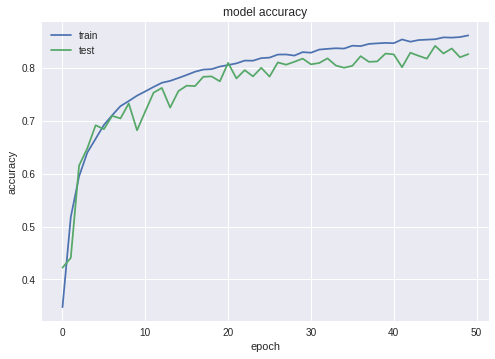

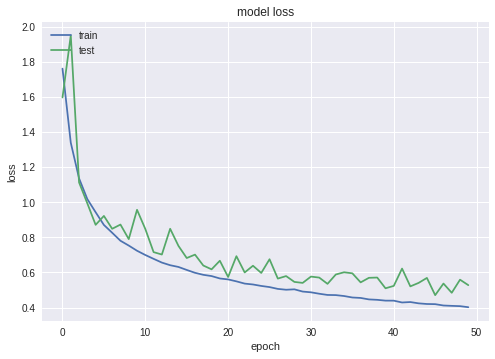

In [33]:
# Plot the graph
print(history.history.keys())
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [64]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 3)    12          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation